# Weighted Average MLP Ensemble

In [1]:
import numpy as np

from itertools import product
from matplotlib import pyplot as plt
from numpy.linalg import norm
from scipy.optimize import differential_evolution
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
# Fit model on dataset

def fit_model(train_X, train_y, validation_X, validation_y):
    train_y_enc = to_categorical(train_y)
    validation_y_enc = to_categorical(validation_y)
    
    # Define model
    model = Sequential()
    model.add(Dense(25, input_dim=2, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # Fit model
    model.fit(train_X, train_y_enc, validation_data=(validation_X, validation_y_enc), epochs=500, verbose=0)
    
    return model

In [3]:
# Make an ensemble prediction for multi-class classification

def ensemble_predictions(members, weights, test_X):
    # Make predictions
    y_hats = [model.predict(test_X) for model in members]
    y_hats = np.array(y_hats)
    
    # Weighted sum across ensemble members
    summed = np.tensordot(y_hats, weights, axes=((0),(0)))
    
    # argmax across classes
    result = np.argmax(summed, axis=1)
    
    return result

In [4]:
# Evaluate a specific number of members in an ensemble

def evaluate_ensemble(members, weights, test_X, test_y):
    # Make prediction
    y_hat = ensemble_predictions(members, weights, test_X)
    
    # Calculate accuracy
    return accuracy_score(test_y, y_hat)

In [5]:
# Normalize a vector to have unit norm

def normalize(weights):
    # calculate l1 vector norm
    result = norm(weights, 1)
    
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    
    # return normalized vector (unit norm)
    return weights / result

In [6]:
# Loss function for optimization process, designed to be minimized

def loss_function(weights, members, test_X, test_y):
    # normalize weights
    normalized = normalize(weights)
    
    # calculate error rate
    return 1.0 - evaluate_ensemble(members, normalized, test_X, test_y)

In [7]:
# Generate 2d classification dataset

X, y = make_blobs(n_samples=1200, centers=3, n_features=2, cluster_std=2, random_state=2)

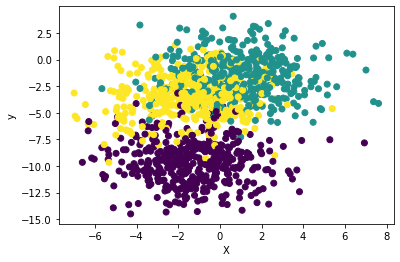

In [8]:
# Scatter plot, dots colored by class value

plt.xlabel('X')
plt.ylabel('y')

plt.scatter(X[:,0], X[:,1], c=y)
plt.show()

In [9]:
# Split into train, validation and test

n_train = 100
n_validation = 700

train_X = X[:n_train, :]
validation_X= X[n_train:n_validation, :]
test_X = X[n_validation:, :]

train_y = y[:n_train]
validation_y = y[n_train:n_validation]
test_y = y[n_validation:]

print(f"train_X:{train_X.shape}, validation_X:{validation_X.shape}, test_X:{test_X.shape}")
print(f"train_y:{train_y.shape}, validation_y:{validation_y.shape}, test_y:{test_y.shape}")

train_X:(100, 2), validation_X:(600, 2), test_X:(500, 2)
train_y:(100,), validation_y:(600,), test_y:(500,)


In [10]:
# Fit all models

n_members = 5
members = [fit_model(train_X, train_y, validation_X, validation_y) for _ in range(n_members)]

In [11]:
# Evaluate each single model on the test set

test_y_enc = to_categorical(test_y)

for i in range(n_members):
    _, test_acc = members[i].evaluate(test_X, test_y_enc, verbose=0)
    print('Model %d: %.3f' % (i+1, test_acc))

Model 1: 0.802
Model 2: 0.798
Model 3: 0.804
Model 4: 0.798
Model 5: 0.800


In [12]:
# Evaluate averaging ensemble (equal weights)

weights = [1.0/n_members for _ in range(n_members)]

score = evaluate_ensemble(members, weights, test_X, test_y)
print('Equal Weights Score: %.3f' % score)

Equal Weights Score: 0.798


In [13]:
# Define bounds on each weight

bound_w = [(0.0, 1.0)  for _ in range(n_members)]

In [14]:
# Arguments to the loss function

search_arg = (members, test_X, test_y)

In [15]:
# Global optimization of ensemble weights

result = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)

In [16]:
# Get the chosen weights

weights = normalize(result['x'])
print('Optimized Weights: %s' % weights)

Optimized Weights: [0.43006787 0.00054106 0.31302877 0.00742014 0.24894216]


In [17]:
# Evaluate chosen weights

score = evaluate_ensemble(members, weights, test_X, test_y)
print('Optimized Weights Score: %.3f' % score)

Optimized Weights Score: 0.808
